<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pygam

In [2]:
pip install graphviz

In [3]:
import pandas as pd        
from pygam import LogisticGAM
from matplotlib import pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_recall_curve) 
from sklearn.model_selection import train_test_split
import pymc3 as pm
import statsmodels.api as sm
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_csv('overloadlog.csv')
#df = df.assign(const=1)
X = df[['CEN','NES','NOR','NTE','OCC','ORI','PEN']] ## Predictors
X = df[['CEN','NES','NOR','NTE','OCC','ORI','PEN','CEN_min','NES_min','NOR_min','NTE_min','OCC_min','ORI_min','PEN_min']] ## Predictors
X = df[['CEN','NES','NOR','NTE','OCC','ORI','PEN']] ## Predictors
y = df['L3']

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 5)
X_train.describe()

,CEN,NES,NOR,NTE,OCC,ORI,PEN
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.546399,3.567721,2.426961,2.730014,3.518402,2.815984,2.604932
std,0.032259,0.066448,0.526349,0.177593,0.095419,0.262973,0.328869
min,3.459301,3.361716,1.260834,2.309358,3.304361,1.659022,1.331144
25%,3.533611,3.530371,2.062744,2.641357,3.407852,2.695375,2.375614
50%,3.546996,3.554772,2.639740,2.750272,3.558160,2.888933,2.604969
75%,3.563515,3.622881,2.832332,2.831338,3.583927,2.972770,2.970841
max,3.628168,3.678227,3.003142,3.060030,3.651794,3.182285,3.041967


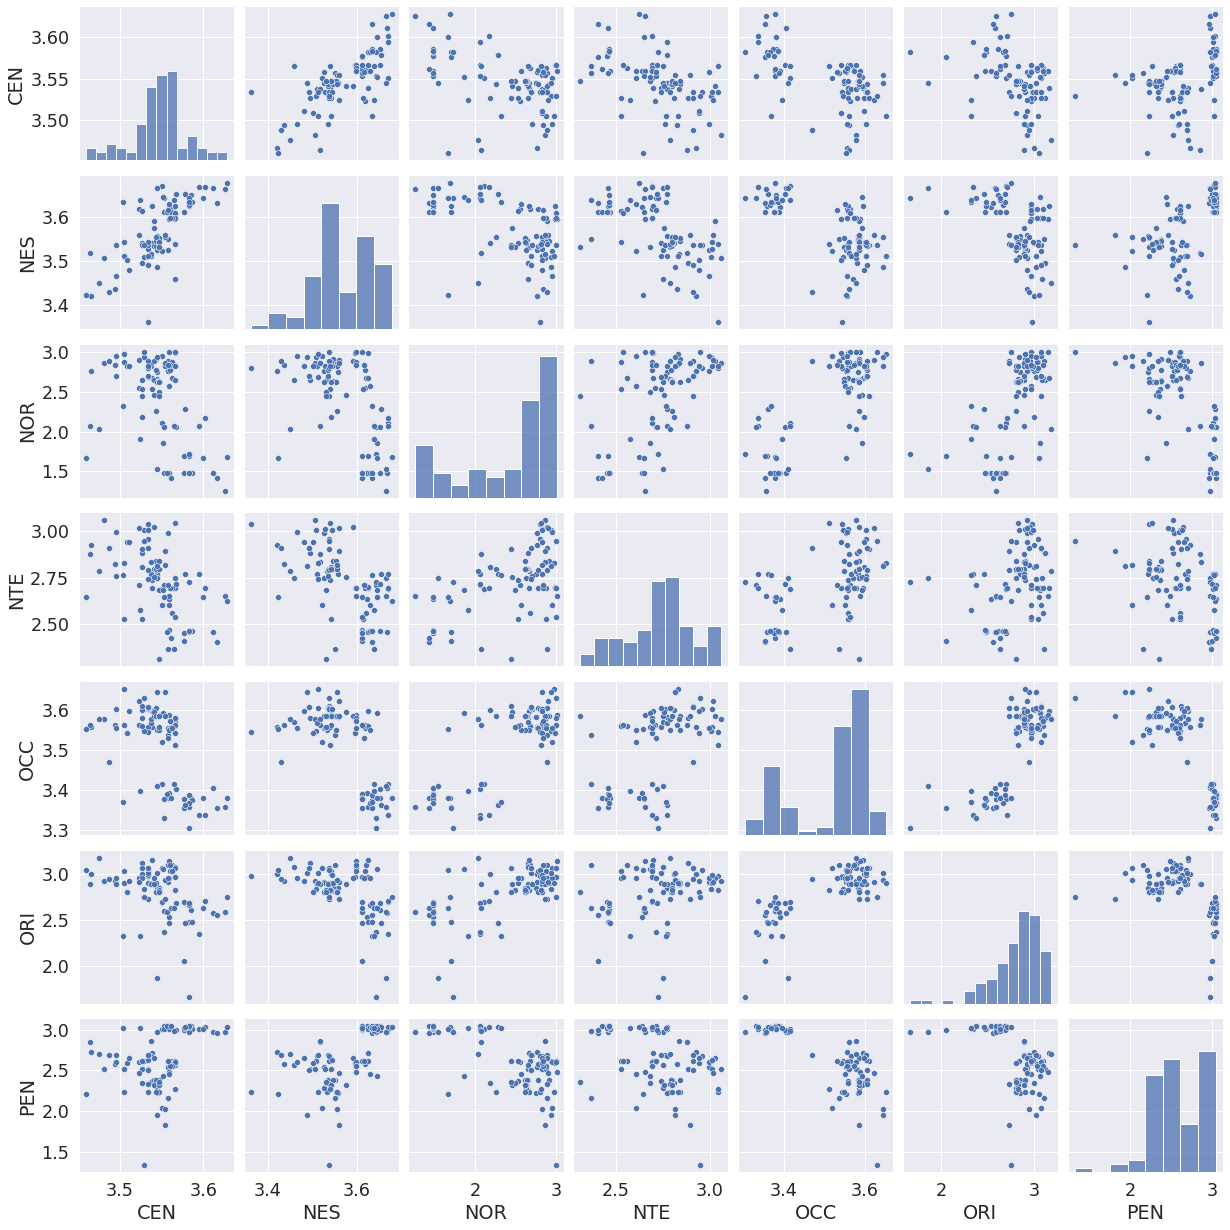

In [5]:
sns.set_theme(style = "ticks")
sns.set(font_scale = 1.6)
sns.pairplot(X_train)

## Regresión logística con la librería statsmodel.

In [16]:
model = sm.Logit(y_train, X_train)
results = model.fit()
logit_result_prediction = results.predict(X_test)
print(results.summary())
#convert y_score into binary decisions    
y_pred = [1 if x > 0.5 else 0 for x in logit_result_prediction]

Optimization terminated successfully.
         Current function value: 0.395603
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                     L3   No. Observations:                  100
Model:                          Logit   Df Residuals:                       93
Method:                           MLE   Df Model:                            6
Date:                Wed, 02 Mar 2022   Pseudo R-squ.:                  0.4293
Time:                        02:54:10   Log-Likelihood:                -39.560
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 5.663e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CEN          -22.7966     10.129     -2.251      0.024     -42.650      -2.944
NES            9.6824      7.

In [17]:
# Exactitud del modelo
print('Test accuracy RegLogit = ', accuracy_score(y_test, y_pred))

#compute confussion matrix 
confussion_matrix = confusion_matrix(y_test, y_pred)
confussion_matrix

Test accuracy RegLogit=  0.6851063829787234


array([[67, 29],
       [45, 94]])

## Regresión lógistica aditiva generalizada (GAM) 

In [8]:
#Fit a GAM
gam = LogisticGAM(max_iter=1000, tol=0.0001, verbose=True).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


In [9]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     14.2398
Link Function:                        LogitLink Log Likelihood:                                   -33.2336
Number of Samples:                          100 AIC:                                               94.9468
                                                AICc:                                             100.8563
                                                UBRE:                                               3.0634
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.5205
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [10]:
# Exactitud del modelo
print('Test accuracy GAM = ', accuracy_score(y_test, gam.predict(X_test)))

#compute confussion matrix 
confussion_matrix = confusion_matrix(y_test, gam.predict(X_test))
print(confussion_matrix)

Test accuracy GAM=  0.8127659574468085
[[ 68  28]
 [ 16 123]]


<Figure size 432x288 with 0 Axes>

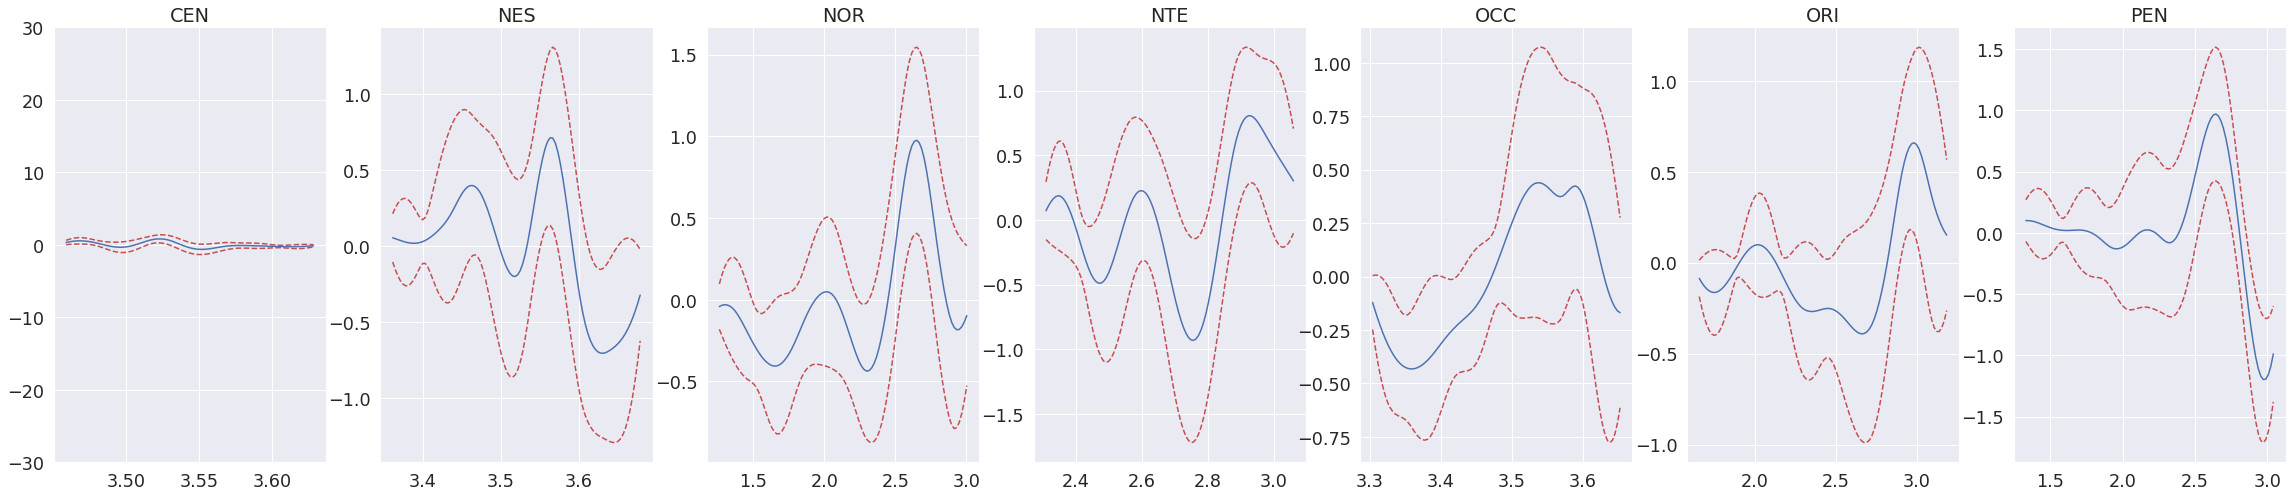

In [11]:
titles = X_test.columns[0:8]
plt.figure()
fig, axs = plt.subplots(1, 7, figsize=(40, 8))

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])
        
plt.show()

## Árboles de decisión

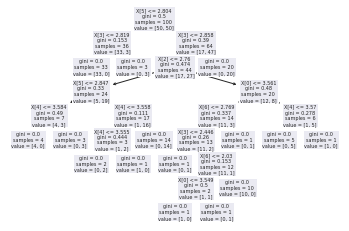

In [12]:
from sklearn import datasets, metrics, model_selection, svm
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_leaf_nodes=40)
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf)
#metrics.plot_roc_curve(clf, X_test, y_test) 
plt.show()

In [13]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("overload") 

'overload.pdf'

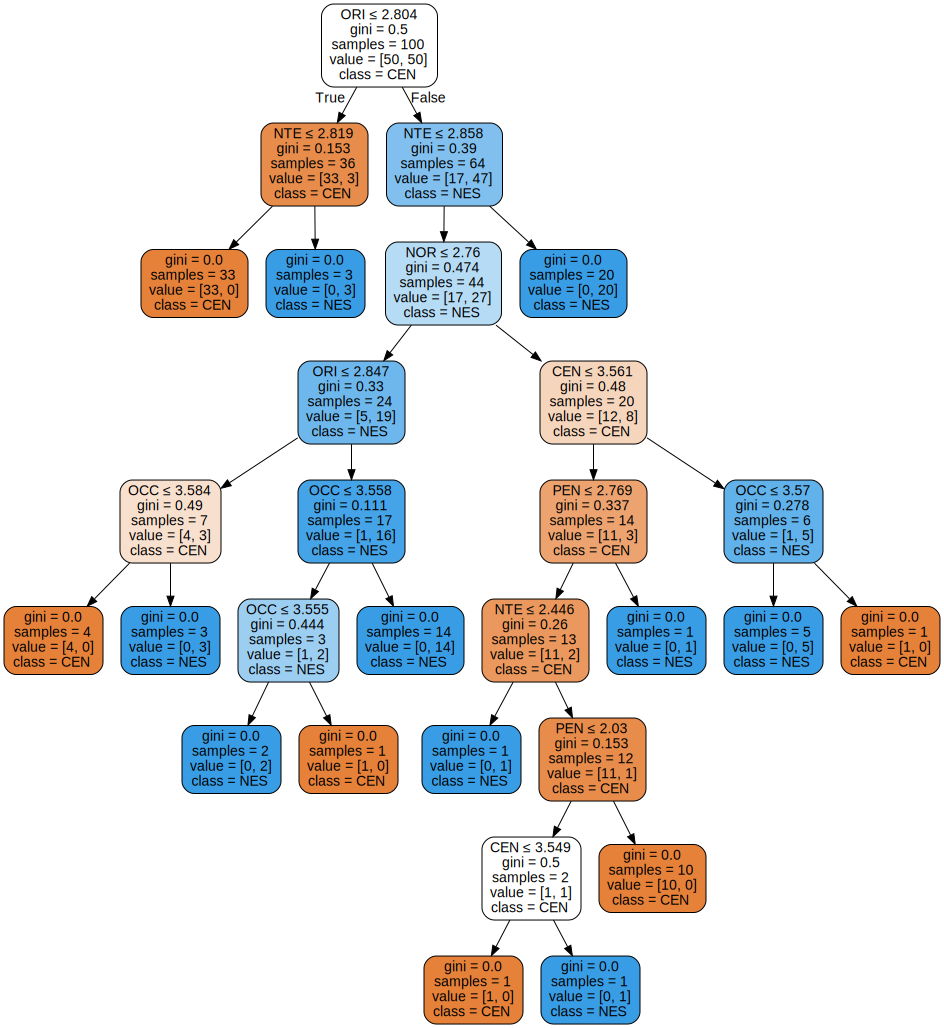

In [14]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_test.columns.values.tolist(),
                                class_names=X_test.columns.values.tolist(),
                                filled=True, 
                                rounded=True, 
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [15]:
# Exactitud del modelo
print('Test accuracy árbol = ', accuracy_score(y_test, clf.predict(X_test)))

#compute confussion matrix 
confussion_matrix = confusion_matrix(y_test, clf.predict(X_test))
print(confussion_matrix)

Test accuracy árbol=  0.7659574468085106
[[ 74  22]
 [ 33 106]]


[Doc LogisticGAM](https://pygam.readthedocs.io/en/latest/api/logisticgam.html)

[A Tour of pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html)

[A example of pyGAM](https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f)

[documentación pyGAM](https://pygam.readthedocs.io/en/latest/)

[pyGAM : Getting Started with Generalized Additive Models in Python](https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f)

[Building interpretable models with Generalized additive models in Python](https://medium.com/just-another-data-scientist/building-interpretable-models-with-generalized-additive-models-in-python-c4404eaf5515)

[Scikit Decision Trees](https://scikit-learn.org/stable/modules/tree.html)

[Post pruning decision trees with cost complexity pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)

[Understanding the decision tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)